# **Clasificador de Gato vs Perro**

Para este desafío, usare una red **neuronal convolucional** para clasificar imágenes de perros y gatos. Utilizará Tensorflow 2.0 y Keras para crear una red neuronal que clasifique correctamente las imágenes de gatos y perros al menos el 63 % de las veces.

Importamos las librerias 

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Conseguimos los datos necesarios

In [ ]:
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Obtengo el número de archivos en cada directorio. Los directorios de train y validation.
# cada uno tiene un subdirectorio de "perro" y "gato"
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables para pre-procesar las imagenes.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Hacemos un procesamiento de las imagenes y las reescalamos para que esten dentro de los 255 pixeles, esto lo hacemos para que haya una norma a la hora de analizar las imagenes

In [3]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(directory=PATH,
                                                         classes=['test'],
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         batch_size=batch_size,
                                                         shuffle=False,)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


Probamos los datos refinados, con la funcion "plotImages" que nos mostrara 5 imagenes al azar

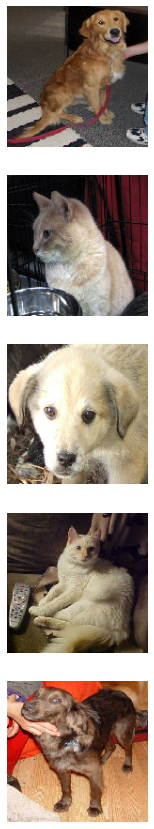

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreamos el train_image_generator usando ImageDataGeneretor

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           validation_split = .2)


con estas lineas de codigo una imagen es ploteada en 5 ocasiones usando diferentes variables

Found 2000 images belonging to 2 classes.


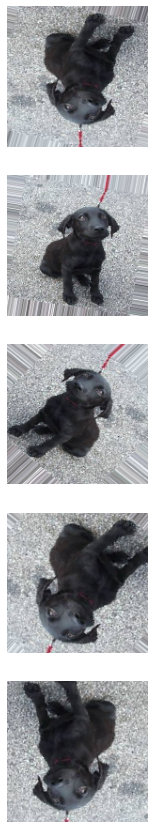

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

Se utiliza el modelo "Keras Sequential". Involucre una pila de capas Conv2D y MaxPooling2D y luego una capa completamente conectada en la parte superior que se activa mediante una función de activación de ReLU.


Compile el modelo pasando los argumentos para configurar el optimizador y la pérdida. Pase también metrics=['accuracy'] para ver la precisión del entrenamiento y la validación para cada époch de entrenamiento.

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

# **Entrenamos al modelo**

In [8]:
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

Epoch 1/15
15/15 [==============================] - 29s 1s/step - loss: 1.5090 - accuracy: 0.5139 - val_loss: 0.6894 - val_accuracy: 0.5056
Epoch 2/15
15/15 [==============================] - 16s 1s/step - loss: 0.6934 - accuracy: 0.5141 - val_loss: 0.6929 - val_accuracy: 0.4967
Epoch 3/15
15/15 [==============================] - 16s 1s/step - loss: 0.6925 - accuracy: 0.5096 - val_loss: 0.6887 - val_accuracy: 0.5156
Epoch 4/15
15/15 [==============================] - 16s 1s/step - loss: 0.6852 - accuracy: 0.5572 - val_loss: 0.6820 - val_accuracy: 0.6239
Epoch 5/15
15/15 [==============================] - 17s 1s/step - loss: 0.6897 - accuracy: 0.5069 - val_loss: 0.6904 - val_accuracy: 0.5011
Epoch 6/15
15/15 [==============================] - 16s 1s/step - loss: 0.6871 - accuracy: 0.5507 - val_loss: 0.6912 - val_accuracy: 0.5413
Epoch 7/15
15/15 [==============================] - 16s 1s/step - loss: 0.6832 - accuracy: 0.5657 - val_loss: 0.6845 - val_accuracy: 0.5926
Epoch 8/15
15/15 [==

Aca analizamos el accuracy del modelo ploteandolo

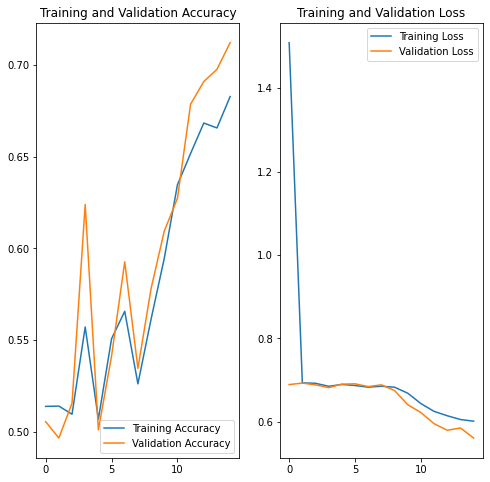

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Ahora es el momento de usar su modelo para predecir si una nueva imagen es un gato o un perro.

En esta celda final, obtenemos la probabilidad de que cada imagen de prueba (de test_data_gen) sea un perro o un gato. las probabilidades son una lista de números enteros.

Llame a la función plotImages y pase las imágenes de prueba y las probabilidades correspondientes a cada imagen de prueba.

Después de ejecutar la celda, debería ver las 50 imágenes de prueba con una etiqueta que muestra el porcentaje de certeza de que la imagen es un gato o un perro. La precisión corresponderá a la precisión que se muestra en el gráfico anterior. Más imágenes de entrenamiento podrían conducir a una mayor precisión.

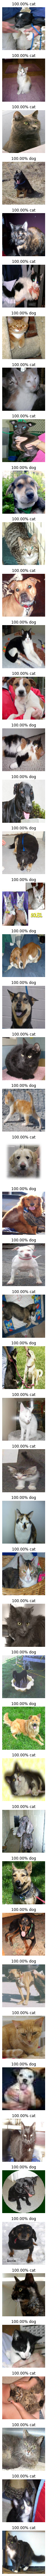

In [10]:
test_images, _ = next(test_data_gen)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(test_images, probabilities=probabilities)

In [11]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"El modelo identifica un {round(percentage_identified, 2)}% de imagenes de perros y gatos.")

if passed_challenge:
  print("Conseguido!")
else:
  print("No conseguido")

El modelo identifica un 0.72% de imagenes de perros y gatos.
Conseguido!
